In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Session 21a : torch mask RCNN
<img src='../../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com"/>

In [2]:
### Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from PIL import Image

In [3]:
# Some basic parameters

inpDir = '../../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'PennFudanPed' # location of the images
modelDir = '../models'
altName = 'mask_rcnn'


RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
EPOCHS = 100 # number of cycles to run
BATCH_SIZE = 32

ALPHA = 0.001
TEST_SIZE = 0.2
IMG_HEIGHT = 200
IMG_WIDTH = 200


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,4),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Load Image

In [4]:
image = read_image(os.path.join(inpDir, subDir, 'PNGImages/FudanPed00046.png'))
mask = read_image(os.path.join(inpDir, subDir, 'PedMasks/FudanPed00046_mask.png'))


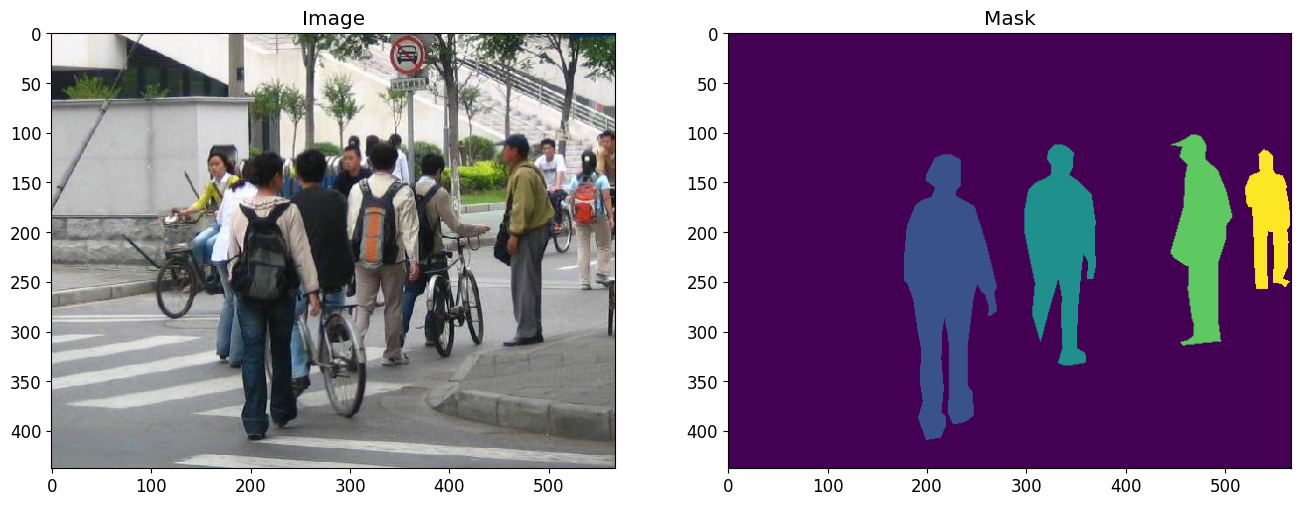

In [5]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

### Prepare a Dataset

In [6]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

### Defining Model

We will be using Mask R-CNN, which is based on top of Faster R-CNN. Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.
<img src = '../../../images/mask_rcnn_fig1.png' />
Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.
<img src = '../../../images/mask_rcnn_fig2.png' />

### Fine tuning from Pretrained

In [7]:
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### Modifying the model to add a different backbone

In [8]:
# load a pre-trained model for classification and return only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features

# ``FasterRCNN`` needs to know the number of output channels in a backbone. 
# For mobilenet_v2, it's 1280 so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial location,
# with 5 different sizes and 3 different aspect ratios. 
# We have a Tuple[Tuple[int]] because each feature map could 
# potentially have different sizes and aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will use to perform 
# the region of interest cropping, as well as the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to # be [0]. 
# More generally, the backbone should return an ``OrderedDict[Tensor]``, 
# and in ``featmap_names`` you can choose which feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

### Object detection and instance segmentation model
In our case, we want to finetune from a pre-trained model, given that our dataset is very small, so we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [9]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model


In [10]:
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [11]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [12]:
from utils import utils
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset(os.path.join(inpDir,subDir), get_transform(train=True))

In [13]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)


In [14]:

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)


{'loss_classifier': tensor(0.1364, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0562, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0367, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0088, grad_fn=<DivBackward0>)}


In [15]:

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [16]:
from utils.engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset(os.path.join(inpDir, subDir), get_transform(train=True))
dataset_test = PennFudanDataset(os.path.join(inpDir, subDir), get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

/home/pks/01_projects/CDAC/DUASP/ImageProcessingDNN/notebooks/utils/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:01:14  lr: 0.000090  loss: 5.0144 (5.0144)  loss_classifier: 0.8437 (0.8437)  loss_box_reg: 0.4261 (0.4261)  loss_mask: 3.7398 (3.7398)  loss_objectness: 0.0019 (0.0019)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 1.2365  data: 0.0185  max mem: 2521
Epoch: [0]  [10/60]  eta: 0:00:25  lr: 0.000936  loss: 2.1711 (2.7169)  loss_classifier: 0.5447 (0.5091)  loss_box_reg: 0.2747 (0.2892)  loss_mask: 1.4512 (1.8886)  loss_objectness: 0.0173 (0.0240)  loss_rpn_box_reg: 0.0053 (0.0060)  time: 0.5018  data: 0.0175  max mem: 2521
Epoch: [0]  [20/60]  eta: 0:00:18  lr: 0.001783  loss: 0.9626 (1.7416)  loss_classifier: 0.2071 (0.3515)  loss_box_reg: 0.2253 (0.2694)  loss_mask: 0.3156 (1.0962)  loss_objectness: 0.0149 (0.0183)  loss_rpn_box_reg: 0.0053 (0.0062)  time: 0.4360  data: 0.0191  max mem: 2828
Epoch: [0]  [30/60]  eta: 0:00:13  lr: 0.002629  loss: 0.6312 (1.3940)  loss_classifier: 0.1418 (0.2815)  loss_box_reg: 0.2498 (0.2828)  loss_mask: 0.2202 (0.8077)  loss_ob

But what do the predictions look like? Let’s take one image in the dataset and verify

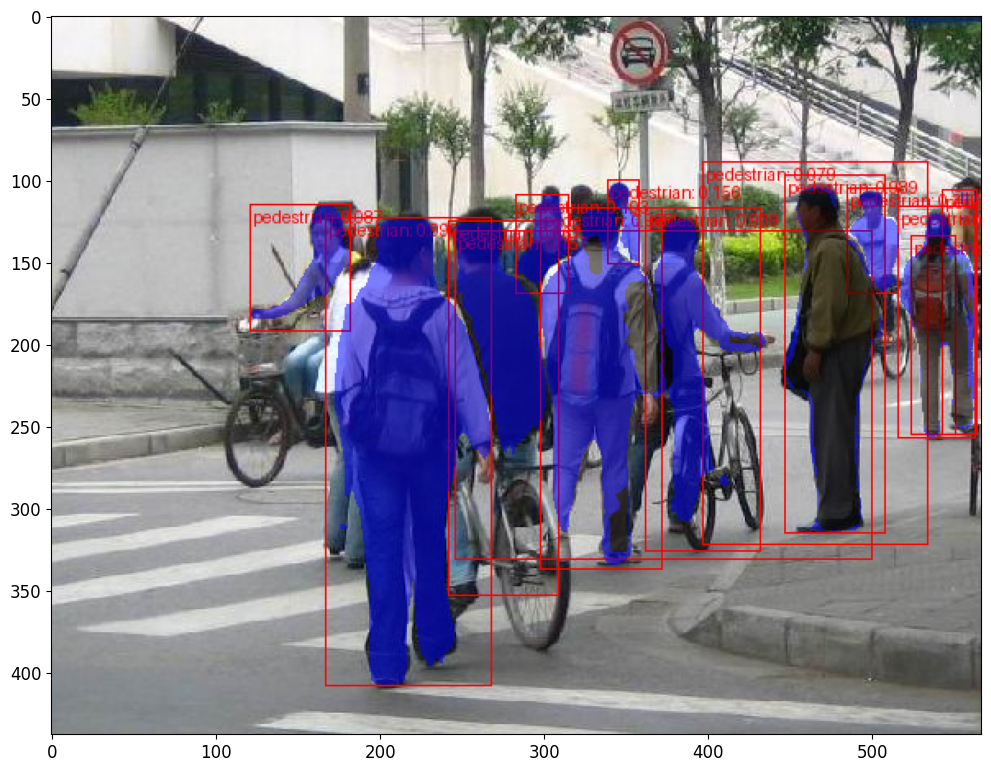

In [17]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image(os.path.join(inpDir, subDir, "PNGImages/FudanPed00046.png"))
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0));


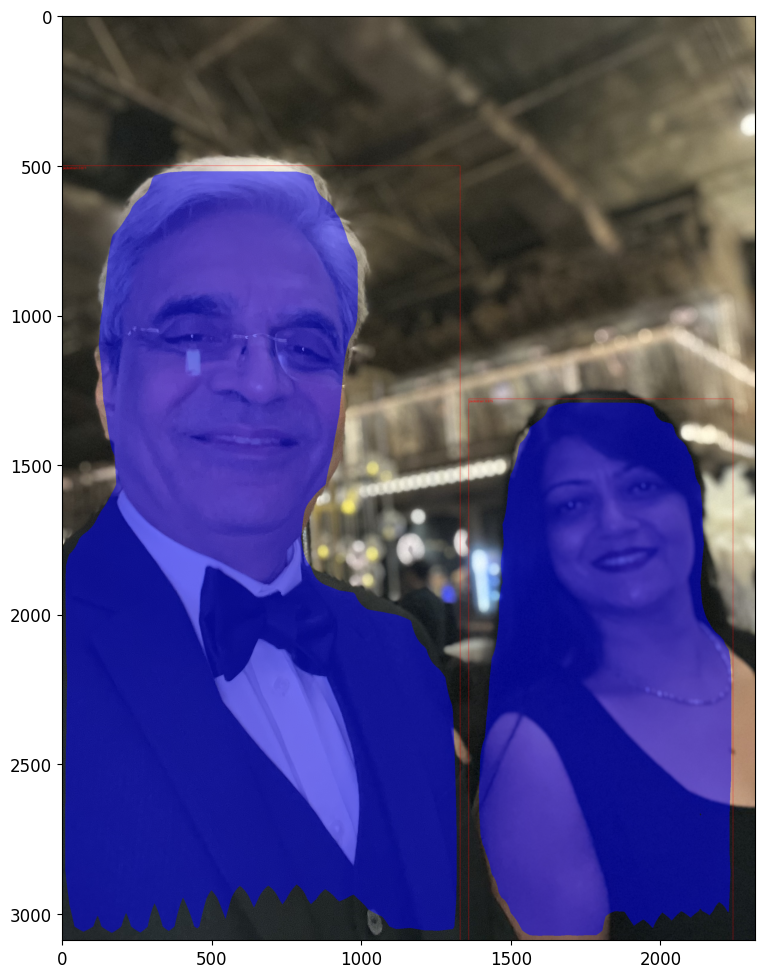

In [20]:
image = read_image(os.path.join(inpDir, 'basic_operations','IMG_E3539.JPG' )) # "Lionel-Messi.png"
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
